In [2]:
import torch
print(torch.cuda.is_available())  # deve retornar True
print(torch.version.cuda)         # deve retornar a versão do cuda

True
12.1


In [3]:
import numpy as np
import yaml
from ultralytics import YOLO
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import shutil
import os

import xml.etree.ElementTree as ET
import glob
import json

# Configuração para que os gráficos apareçam no notebook
%matplotlib inline

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [ ]:
# Pega o diretório atual automaticamente
BASE_DIR = Path().resolve()

# Sobe um nível e entra na pasta dataset
DATASET_DIR = BASE_DIR.parent / "dataset"

print("Caminho atual:", BASE_DIR)
print("Caminho dataset:", DATASET_DIR)

## Auxiliary Functions


In [16]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]


def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


In [12]:
classes = []
input_dir = "../dataset/pools/labels/"
output_dir = "../dataset/labels_yolo/"
image_dir = "../dataset/pools/images/"

# create the labels folder (output directory)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))
# loop through each 
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))
    
print("XML to YOLO Format Done!!")

XML to YOLO Format Done!!


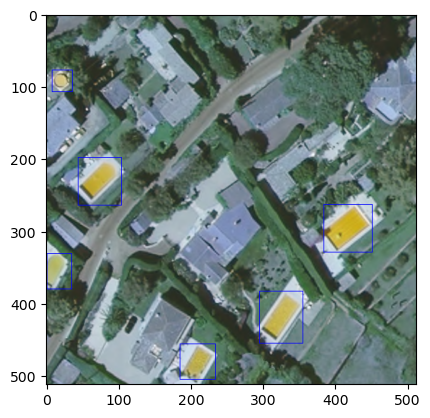

In [25]:
img = cv2.imread("../dataset/pools/images/CANNES_TILES_512x512.13.png")
dh, dw, _ = img.shape

fl = open("../dataset/labels_yolo/CANNES_TILES_512x512.13.txt", 'r')
data = fl.readlines()
fl.close()

for dt in data:

    _, x, y, w, h = map(float, dt.split(' '))

    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.imshow(img)
plt.show()

# Train Test Split


There shouldn't be labels, train, val, test folder in working directory

In [ ]:
IMAGES_PATH = DATASET_DIR / "pools/images"
LABELS_PATH = DATASET_DIR / "labels_yolo/"

# Read labels
labels = [file for file in os.listdir(LABELS_PATH) if file.endswith('.txt')]

# Split data
train, test = train_test_split(labels, test_size=0.15, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

os.makedirs("test/images", exist_ok=True)
os.makedirs("test/labels", exist_ok=True)
os.makedirs("train/images", exist_ok=True)
os.makedirs("train/labels", exist_ok=True)
os.makedirs("valid/images", exist_ok=True)
os.makedirs("valid/labels", exist_ok=True)

def move_files_to_dir(files, dirname):
    for label_filename in files:
        image_filename = f"{label_filename[:-4]}.png"
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{dirname}/images/{image_filename}")
        shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{dirname}/labels/{label_filename}")

# Move splits to folders
move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")

print("Train Test Split Done!!")

# Training Model


### Create a dataset yaml config

In [1]:
def create_dataset_yaml():
    """
    Cria arquivo de configuração do dataset
    """
    dataset_config = {
        'path': '.',  
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        
        'nc': 1,            # Número de classes (só há uma: pool)
        'names': ['pool']   # O nome da nossa classe (índice 0)
    }

    yaml_path = 'dataset/pools_dataset.yaml'    # onde o YAML será salvo
    yaml_path = os.path.join(DATASET_DIR, 'pools_dataset.yaml')

    with open(yaml_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False)

    print(f"Arquivo dataset.yaml criado: {yaml_path}")
    return yaml_path

In [19]:
yaml_config = create_dataset_yaml()

Arquivo dataset.yaml criado: C:\Users\Seares\Desktop\Programação\Projetos\Cases Técnicos\CloudWalk-case\dataset\pools_dataset.yaml


In [21]:
model = YOLO('yolov8m.pt')

results = model.train(
    data=yaml_config,
    epochs=20,
    imgsz=512,  
    batch=16,    # ajustado pra 8GB de VRAM
    device=0 if torch.cuda.is_available() else 'cpu',
    project='results_pools',
    name='pools_detector_v1',
    save=True,
    plots=True,
    patience=10,
    save_period=10,
    verbose=True
)


Ultralytics 8.3.218  Python-3.10.18 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\Seares\Desktop\Programao\Projetos\Cases Tcnicos\CloudWalk-case\dataset\pools_dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pools_detector_v13, nbs=64, nms=False, opset=None, optimize=Fals

## Fazendo predict



image 1/1 C:\Users\Seares\Desktop\Programao\Projetos\Cases Tcnicos\CloudWalk-case\notebooks\..\dataset\sao_paulo\images\sp_Zona_Sul_0308_-23.636389_-46.702231.png: 512x512 5 pools, 14.4ms
Speed: 1.8ms preprocess, 14.4ms inference, 4.3ms postprocess per image at shape (1, 3, 512, 512)


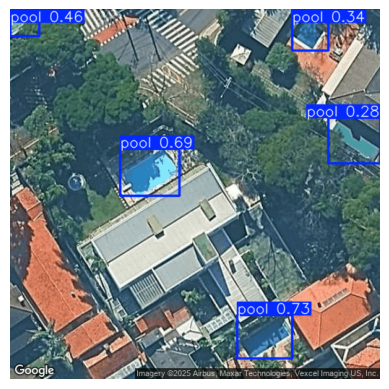

In [6]:
best_model = YOLO("results_pools/pools_detector_v13/weights/best.pt")

preds = best_model.predict("../dataset/sao_paulo/images/sp_Zona_Sul_0308_-23.636389_-46.702231.png")

result_img = preds[0].plot()  # BGR
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

plt.imshow(result_img)
plt.axis("off")
plt.show()
